# Riemann scheme. 

Lets consider same setup as in [ex_3a](https://github.com/AST-Course/AST5110/blob/main/ex_3a.ipynb) Burgers’ equation, i.e.,

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0   \tag{1}$$ 

for the domain $x \in (x_0, x_f)$ with $x_0 = −1.4$, $x_f = 2.0$ with initial condition:

$$u(x,t=0) = A\left[\tanh\left(\frac{x+x_c}{W}\right)-\tanh\left(\frac{x-x_c}{W}\right)\right]   \tag{2}$$

whereby $A = 0.02$ , $x_c = 0.70$, $W = 0.1$. Let the solution evolve until time $t_f = 100$. However, let's now implement a new time-step method. Find the conservative form of the equation and implement a Rieman solver [wiki:Rieman Solvers](https://github.com/AST-Course/AST5110/wiki/Riemann-solvers). 

Add this to your library and solve the previous simulation imposing the CFL condition. For this exercise, fill in `nm_lib` the function `evolv_Rie_uadv_burgers`. 

#### In this notebook it is the pseudocode, the implemented code is found on line 520 in `nm_lib.py`

In [45]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
from IPython.display import HTML
import importlib
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

In [46]:
def u_init(xx, A=0.02, xc=0.7, W=0.1):
    ans = A*(np.tanh((xx + xc)/W) - np.tanh((xx - xc)/W))
    return ans
    
def u(xx, t, a):
    X = (xx - a*t)
    L = xx[-1] - xx[0]
    new_X = (X + L/2)%L - L/2
    return u_init(new_X)

x0 = -1.4
xf = 2.0
nump = 257

xx = np.arange(nump)/(nump - 1) * (xf - x0) + x0

#### 1 step

Compute left and right of $u$, i.e., $u_L$ and $u_R$. Note that $u_R = u_{i+1}$ and $u_L = u_i$

In [47]:
uu = u_init(xx)
u_L = uu[:-1]
u_R = uu[1:]
u_L = np.pad(u_L, (0, 1), 'wrap')
u_R = np.pad(u_R, (1, 0), 'wrap')

t, ut = nm.evolv_Rie_uadv_burgers(xx, uu, 10)

#### Gets the left and right sides of the `cells` $u_L$ and $u_R$, and fixing the boundary limits


#### 2 step
Rewrite the eq 1 in a conservative form to get the Flux. Compute from the left and right variable (u_L$ and $u_R$) the corresponding flux, i.e., $F_L$ and $F_R$


#### From equation (1) I observe that the we can rewrite it as

$$
\frac{\partial u}{\partial t} + r_{RL} \frac{\partial u}{\partial x}= 0
$$

And can then calculate the linear flux as

$$
F(u) = r_{RL} \cdot u
$$

But since $r_{RL}=u$ And we have the same on each side, we need to divide by two.

$$
F_{\alpha}(u) = \frac{u_{\alpha}^{2}}{2}
$$
Where $\alpha$ is the left or right side.

In [48]:
def F(u):
    return .5*u**2

In [49]:
F_L = F(u_L)
F_R = F(u_R)


#### 3 step
Compute the propagating speed. This will be the derivatie of the flux with respect to variable $u$ in absolute values and select the largest between the left and right shells ($v_a$).


In [50]:
v_a = np.max([np.abs(u_R), np.abs(u_L)], axis=0)

#### Above we get the maximum propogating speed of the right and left cells.


#### 4 step
Compute the interface fluxes (Rusanov)

$F^*_{i+1/2}=\frac{F_R+F_L}{2} - \frac{v_a}{2} (U_R -U_L)$

Note that $F^*_{i+1/2}$ is half grid shifted


In [51]:
rhs = .5*(F_R + F_L) - .5*v_a*(u_R - u_L)


#### 5 step
Advance in time $u^{n+1}=u^n - dt\times (F^*_{i+1/2}-F^*_{i-1/2})$. 

What is dt taking into account the phase speed ($v_a$)? 


In [52]:
dx = xx[1] - xx[0]
dt = np.min((dx/np.abs(v_a)))
u_new = uu - dt * (rhs - np.roll(rhs, 1))/dx 

#### The correct formula has a division on $dx$ so that has been added.

In [54]:
nt = 300
t, unnt = nm.evolv_Rie_uadv_burgers(xx, uu, nt, cfl_cut=0.98)
t, un_lax = nm.evolv_Lax_uadv_burgers(xx, uu, nt, 
            ddx=lambda x, y: nm.deriv_cent(x, y), bnd_limits=[1, 0])

#### Implemented and tested from `nm_lib.py`

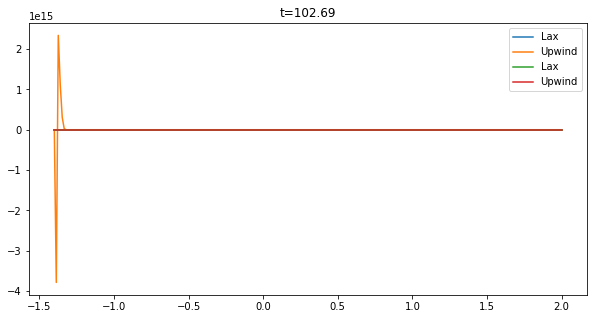

In [55]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

anim = nm.animation(xx, un_lax, unnt, nt, t, label_1="Lax", label_2="Riemann")
HTML(anim.to_jshtml())

Is this method less or more diffusive than Lax method? Find the analytical solution and compare. Where and when is better or worse than the Lax method? 

The different approximations of Rieman solvers uses different ways to estimate $F^*$ and phase velocity ($v_a$). Otherwise they do the same steps. 

---
## TVD scheme. 

Combine the Lax method with the Rieman solver using a flux limiter scheme. For this, one needs to identify how large are the gradients. Lets define: 

$$r^{+}_i = \frac{u_i-u_{i-1}}{u_{i+1}+u_i}$$

What kind of properties do you see on $r^{+}_i$? e.g., what happens when $r\ge0$? or $r\le0$? 

now lets consider the following flux limiter: 

$$\phi = max\left(0,min\left(\theta r,\frac{1+r}{2},\theta \right)\right),\, \theta =[1,2]$$

Finally, combine the Lax from previous excersice with the Riemann solver using the flux limiter as follows: 

$$u^{n+1}_i = u^n_i + dt (f^n_{i+1/2}-f^n_{i-1/2})$$

Where 

$$f^n_{i+1/2} = f^{Riemann}_{i+1/2} + \phi^n_i (f^{L}_{i+1/2}-f^{Riemann}_{i+1/2})$$



When becomes purely Rieman solver? And Lax? Which others methods you can find depending on what is $r$ of $\phi$. 